In [1]:
 !pip install -q -U 'tensorflow-text==2.8.*'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 45.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 498.0/498.0 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.3/462.3 KB 31.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 48.6 MB/s eta 0:00:00


In [2]:
!pip install -q tf-models-official

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 36.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.9/238.9 KB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 44.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 KB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 31.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 KB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 662.4/662.4 KB 35.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.1/352.1 KB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 35.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 42.8 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
import re
import time
import unicodedata
import datetime
import pathlib
import json
from pathlib import Path

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras import layers

import tensorflow_hub as hub
import tensorflow_models as tfm

import tensorflow_text as text
from tensorflow_text.tools.wordpiece_vocab import bert_vocab_from_dataset as bert_vocab

In [5]:
tf.get_logger().setLevel('ERROR')
tf.config.run_functions_eagerly(True)

### Variabili Globali

In [6]:
# PARAMETRI GLOBALI
root_folder = 'drive/MyDrive/BERT/'

# DATI
data_folder_name = 'data'
data_filename = 'dataset_dantesco.csv'
train_filename = 'train_dataset_dantesco.csv'

DATA_PATH = os.path.abspath(os.path.join(root_folder, data_folder_name))
data_filenamepath = os.path.abspath(os.path.join(DATA_PATH, data_filename))
train_data_filenamepath = os.path.abspath(os.path.join(DATA_PATH, train_filename))

# PATH LOG Tensorboard
PATH_LOG = 'logs/fit/transformer_no_bert_dante'
PATH_LOG = os.path.abspath(os.path.join(root_folder, PATH_LOG))
log_dir =  os.path.abspath(os.path.join(PATH_LOG, datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))) 
log_history = os.path.abspath(os.path.join(PATH_LOG, 'histrory.json'))

# PATH WEIGHTS Tensorboard
PATH_WEIGHTS = 'weights/transformer_no_bert_dante'
PATH_WEIGHTS = os.path.abspath(os.path.join(root_folder, PATH_WEIGHTS))
checkpoint_path = os.path.abspath(os.path.join(PATH_WEIGHTS, 'cp.ckpt'))

# VOCABOLARIO
vocab_folder = 'vocab'
ita_vocab_finalname = 'ita_vocab_dante.txt'
dan_vocab_finalname = 'dan_vocab_dante.txt'

VOCAB_PATH = os.path.abspath(os.path.join(root_folder, vocab_folder))
ita_vocab_filenamepath = os.path.abspath(os.path.join(VOCAB_PATH, ita_vocab_finalname))
dan_vocab_filenamepath = os.path.abspath(os.path.join(VOCAB_PATH, dan_vocab_finalname))

## Parametri Modello

In [7]:
# parametri per il modello
ORIGINAL_COLUMN = 'Original'
TRANSLATE_COLUMN = 'Translate'

# parametri per il modello
NUM_SAMPLES = 68248 
TRAIN = 18016 
VALIDATION = 6016
N_VALIDATION = 1
TEST = 100

MAX_VOCAB_SIZE = 20000 # portato da 20.0000 a 200.000
EMBEDDING_DIM = 64  # --> 256  Densa non lineare relu --> 64  Densa non lineare relu (oppure Conv1D kernel=1)
HIDDEN_DIM = 1024 # numero di celle nei layer ricorrenti nascosti

BATCH_SIZE = 32
BUFFER_SIZE = 2000
MAX_SEQ_LENGTH = 64

NUM_LAYERS = 1 # Numero di layer di Encoder e Decoder del Transformer
NUM_HEADS = 8 # Numero di meccanismi di multi-head attention
FF_DIM = 16 # Numero di celle dei Layer Feed Forward
DROPUOT = 0.5

# Ottimizzatore Adam
LEARNING_RATE_ADAM = 1e-4
BETA_1 = 0.66
BETA_2 = 0.999
EPOCHS_ADAM = 25

# IMPOSTO IL DEBUG A TRUE 
debug = True
training = True

## Dataset

In [8]:
exist_data_file = Path(train_data_filenamepath)

if not exist_data_file.exists():
  # Caricamento dataset: frasi in inglese, frasi in italiano
  df = pd.read_csv(
    data_filenamepath,
    usecols=[ORIGINAL_COLUMN, TRANSLATE_COLUMN],
    names=[ORIGINAL_COLUMN, TRANSLATE_COLUMN],
    dtype={ORIGINAL_COLUMN: str, TRANSLATE_COLUMN: str}
  )

  # Mischio il dataset in modo che sia più uniforme tra train e test
  df = df.iloc[np.random.permutation(df.index)].reset_index(drop=True)
  df = df.iloc[:TRAIN+VALIDATION+TEST]

  print(df.iloc[-4:], '\n')

  df.to_csv(train_data_filenamepath, header=False, index=False, sep='|', columns=[ORIGINAL_COLUMN, TRANSLATE_COLUMN])

In [9]:
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

def preprocess_sentence(w):
  '''
  Preprocessing dei testi di input, impostando tutti i caratteri
  minuscoli, aggiungendo uno spazio prima di ogni punto e sostituendo
  qualsiasi carattere con uno spazio se non è compreso nel seguente elenco:
  (a-z, A-Z, ".", "?", "!", ",")
  '''
  w = unicode_to_ascii(w.lower().strip())

  # inserimento di uno spazio tra ogni parola e il successivo punto,
  # punto esclamativo, punto interrogativo e virgola
  # esempio: "ciao, come và?" => "ciao , come và ?"
  w = re.sub(r"([?.!,])", r" \1 ", w) # inserimento di uno spazio

  # sostituzione dei caratteri non desiderati con uno spazio
  w = re.sub(r"[^a-zA-Z?.!,]+", " ", w)

  w = re.sub(r'[" "]+', " ", w) # rimozione di più spazi consecutivi
  return w

In [10]:
df = pd.read_csv(
  train_data_filenamepath,
  usecols=[ORIGINAL_COLUMN, TRANSLATE_COLUMN],
  names=[ORIGINAL_COLUMN, TRANSLATE_COLUMN],
  sep = '|'
)

# Preprocessing dei dati di Input
input_data = df[TRANSLATE_COLUMN].apply(lambda x : preprocess_sentence(x)).tolist()

# Preprocessing dei dati Target con aggiunta del token di fine frase
target_data = df[ORIGINAL_COLUMN].apply(lambda x : preprocess_sentence(x)).tolist()

train_input_data = input_data[:TRAIN]
train_target_data = target_data[:TRAIN]

validation_input_data = input_data[TRAIN:TRAIN+VALIDATION]
validation_target_data = target_data[TRAIN:TRAIN+VALIDATION]

test_input_data = input_data[TRAIN+VALIDATION:TRAIN+VALIDATION+TEST]
test_target_data = target_data[TRAIN+VALIDATION:TRAIN+VALIDATION+TEST]

print(f'Dati totali presenti nel Dataset               : {len(df)}')
print(f'Dati totali presenti nel Dataset di Train      : {len(train_input_data)}')
print(f'Dati totali presenti nel Dataset di Validation : {len(validation_input_data)}')
print(f'Dati totali presenti nel Dataset di Test       : {len(test_input_data)}\n')


print('-----------TRAIN SET--------------')
print(train_input_data[-4:])
print(train_target_data[-4:])
print('-----------VALIDATION SET---------------')
print(validation_input_data[-4:])
print(validation_target_data[-4:])
print('-----------TEST SET---------------')
print(test_input_data[-4:])
print(test_target_data[-4:])

Dati totali presenti nel Dataset               : 24132
Dati totali presenti nel Dataset di Train      : 18016
Dati totali presenti nel Dataset di Validation : 6016
Dati totali presenti nel Dataset di Test       : 100

-----------TRAIN SET--------------
['che ignoranza e questa che ti assilla ? ', 'sopra di loro visibilmente nel vento si muovevano . ', 'dei tuoi fratelli stanchi le teste miserabili ! . ', 'nessuno e mai risorto senza credere in cristo , ']
['quanta ignoranza e quella che v offende ! ', 'sovr essi in vista al vento si movieno . ', 'le teste de fratei miseri lassi . ', 'non sali mai chi non credette n cristo , ']
-----------VALIDATION SET---------------
['davvero i giochi fuorvianti della stregoneria . ', 'bisogna stare attenti a non precipitare troppo . ', 'marcia era cosi contenta dei miei occhi mentre ero ancora viva . ', ' quanto ci vorra prima che ti riveda ? ']
['de le magiche frode seppe l gioco . ', 'non sien le genti , ancor , troppo sicure', 'tutti cantavan bene

### Analisi Dati

In [11]:
print(f'Esempi nel Dataset di Train                            : {len(train_input_data)}')
print(f'Frase più corta in Italiano nel Dataset di Train       : {min(train_input_data, key = len)}')
print(f'Frase più corta in Dantesco nel Dataset di Train       : {min(train_target_data, key = len)}')
print(f'Frase più lunga in Italiano nel Dataset di Train       : {max(train_input_data, key = len)}')
print(f'Frase più lunga in Dantesco nel Dataset di Train       : {max(train_target_data, key = len)}')
print('---------------------------------------------------------------------------------------')
print(f'Esempi nel Dataset di Validation                       : {len(validation_input_data)}')
print(f'Frase più corta in Italiano nel Dataset di Validation  : {min(validation_input_data, key = len)}')
print(f'Frase più corta in Dantesco nel Dataset di Validation  : {min(validation_target_data, key = len)}')
print(f'Frase più lunga in Italiano nel Dataset di Validation  : {max(validation_input_data, key = len)}')
print(f'Frase più lunga in Dantesco nel Dataset di Validation  : {max(validation_target_data, key = len)}')
print('---------------------------------------------------------------------------------------')
print(f'Esempi nel Dataset di Test                             : {len(test_input_data)}')
print(f'Frase più corta in Italiano nel Dataset di Test        : {min(test_input_data, key = len)}')
print(f'Frase più corta in Dantesco nel Dataset di Test        : {min(test_target_data, key = len)}')
print(f'Frase più lunga in Italiano nel Dataset di Test        : {max(test_input_data, key = len)}')
print(f'Frase più lunga in Dantesco nel Dataset di Test        : {max(test_target_data, key = len)}')

Esempi nel Dataset di Train                            : 18016
Frase più corta in Italiano nel Dataset di Train       : e poi ho detto 
Frase più corta in Dantesco nel Dataset di Train       : a vera vita non e
Frase più lunga in Italiano nel Dataset di Train       : l impatto sull ambiente e sull ambiente di lavoro e di gran lunga superiore a quello degli altri paesi . 
Frase più lunga in Dantesco nel Dataset di Train       : e sta n su quel , piu che n su l altro , eretto . 
---------------------------------------------------------------------------------------
Esempi nel Dataset di Validation                       : 6016
Frase più corta in Italiano nel Dataset di Validation  : disse non temere
Frase più corta in Dantesco nel Dataset di Validation  : a vera vita non e
Frase più lunga in Italiano nel Dataset di Validation  : quelli che si aggiravano in questo modo formavano il maggior numero di persone . 
Frase più lunga in Dantesco nel Dataset di Validation  : la mente in voi , che l

## Tokenizer

Carico il modello di tokenizer creato utilizzzando il set di dati a disposizione

In [12]:
dataset = tf.data.Dataset.from_tensor_slices((input_data, target_data))
dataset = dataset.shuffle(len(input_data)).batch(BATCH_SIZE, drop_remainder=True)

train_ita = dataset.map(lambda ita, dan: ita)
train_dan = dataset.map(lambda ita, dan: dan)

bert_tokenizer_params=dict(lower_case=True)
reserved_tokens=["[PAD]", "[UNK]", "[START]", "[END]"]

bert_vocab_args = dict(
    # The target vocabulary size
    vocab_size = MAX_VOCAB_SIZE,
    # Reserved tokens that must be included in the vocabulary
    reserved_tokens=reserved_tokens,
    # Arguments for `text.BertTokenizer`
    bert_tokenizer_params=bert_tokenizer_params,
    # Arguments for `wordpiece_vocab.wordpiece_tokenizer_learner_lib.learn`
    learn_params={},
)

/usr/local/lib/python3.8/dist-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [13]:
def write_vocab_file(filepath, vocab):
  with open(filepath, 'w') as f:
    for token in vocab:
      print(token, file=f)

In [14]:
exist_vocab = Path(ita_vocab_filenamepath)

if not exist_vocab.exists():
  ita_vocab = bert_vocab.bert_vocab_from_dataset(
      train_ita.batch(MAX_VOCAB_SIZE).prefetch(tf.data.AUTOTUNE),
      **bert_vocab_args
  )

  write_vocab_file(ita_vocab_filenamepath, ita_vocab)

In [15]:
exist_vocab = Path(dan_vocab_filenamepath)

if not exist_vocab.exists():
  dan_vocab = bert_vocab.bert_vocab_from_dataset(
      train_dan.batch(MAX_VOCAB_SIZE).prefetch(tf.data.AUTOTUNE),
      **bert_vocab_args
  )

  write_vocab_file(dan_vocab_filenamepath, dan_vocab)

In [16]:
# en_tokenizer = text.BertTokenizer(en_vocab_filenamepath, **bert_tokenizer_params)
# it_tokenizer = text.BertTokenizer(it_vocab_filenamepath, **bert_tokenizer_params)

In [17]:
START = tf.argmax(tf.constant(reserved_tokens) == "[START]")
END = tf.argmax(tf.constant(reserved_tokens) == "[END]")

def add_start_end(ragged):
  count = ragged.bounding_shape()[0]
  starts = tf.fill([count,1], START)
  ends = tf.fill([count,1], END)
  x = tf.concat([starts, ragged, ends], axis=1)
  return x

def cleanup_text(reserved_tokens, token_txt):
  # Drop the reserved tokens, except for "[UNK]".
  bad_tokens = [re.escape(tok) for tok in reserved_tokens if tok != "[UNK]"]
  bad_token_re = "|".join(bad_tokens)

  bad_cells = tf.strings.regex_full_match(token_txt, bad_token_re)
  result = tf.ragged.boolean_mask(token_txt, ~bad_cells)

  # Join them into strings.
  result = tf.strings.reduce_join(result, separator=' ', axis=-1)

  return result

### Creo la Classe Custom Tokenizer

In [18]:
class CustomTokenizer(tf.Module):
  def __init__(self, reserved_tokens, vocab_path):
    self.tokenizer = text.BertTokenizer(vocab_path, lower_case=True)
    self._reserved_tokens = reserved_tokens
    self._vocab_path = tf.saved_model.Asset(vocab_path)

    vocab = pathlib.Path(vocab_path).read_text().splitlines()
    self.vocab = tf.Variable(vocab)

    ## Create the signatures for export:   

    # Include a tokenize signature for a batch of strings. 
    self.tokenize.get_concrete_function(
        tf.TensorSpec(shape=[None], dtype=tf.string))
    
    # Include `detokenize` and `lookup` signatures for:
    #   * `Tensors` with shapes [tokens] and [batch, tokens]
    #   * `RaggedTensors` with shape [batch, tokens]
    self.detokenize.get_concrete_function(
        tf.TensorSpec(shape=[None, None], dtype=tf.int64))
    self.detokenize.get_concrete_function(
          tf.RaggedTensorSpec(shape=[None, None], dtype=tf.int64))

    self.lookup.get_concrete_function(
        tf.TensorSpec(shape=[None, None], dtype=tf.int64))
    self.lookup.get_concrete_function(
          tf.RaggedTensorSpec(shape=[None, None], dtype=tf.int64))

    # These `get_*` methods take no arguments
    self.get_vocab_size.get_concrete_function()
    self.get_vocab_path.get_concrete_function()
    self.get_reserved_tokens.get_concrete_function()
    
  @tf.function
  def tokenize(self, strings):
    enc = self.tokenizer.tokenize(strings)
    # Merge the `word` and `word-piece` axes.
    enc = enc.merge_dims(-2,-1)
    enc = add_start_end(enc)
    return enc

  @tf.function
  def detokenize(self, tokenized):
    words = self.tokenizer.detokenize(tokenized)
    return cleanup_text(self._reserved_tokens, words)

  @tf.function
  def lookup(self, token_ids):
    return tf.gather(self.vocab, token_ids)

  @tf.function
  def get_vocab_size(self):
    return tf.shape(self.vocab)[0]

  @tf.function
  def get_vocab_path(self):
    return self._vocab_path

  @tf.function
  def get_reserved_tokens(self):
    return tf.constant(self._reserved_tokens)

In [19]:
tokenizers = tf.Module()
tokenizers.ita = CustomTokenizer(reserved_tokens, ita_vocab_filenamepath)
tokenizers.dan = CustomTokenizer(reserved_tokens, dan_vocab_filenamepath)

### Analisi Dati Tokenizzati

In [20]:
print(f'Vocabolario Italiano : {tokenizers.ita.get_vocab_size()}')
print(f'Vocabolario Dantesco : {tokenizers.dan.get_vocab_size()}')

Vocabolario Italiano : 2631
Vocabolario Dantesco : 2746


In [21]:
print(input_data[-2:])
print(tokenizers.ita.tokenize(input_data[-2:]))
print(keras.preprocessing.sequence.pad_sequences(tokenizers.ita.tokenize(input_data[-2:]).numpy(), maxlen=MAX_SEQ_LENGTH, padding='post'))
print(tokenizers.ita.detokenize(tokenizers.ita.tokenize(input_data[-2:])))
print('------------------------------------------------------------------')
print(target_data[-2:])
print(tokenizers.dan.tokenize(target_data[-2:]))
print(keras.preprocessing.sequence.pad_sequences(tokenizers.dan.tokenize(target_data[-2:]).numpy(), maxlen=MAX_SEQ_LENGTH, padding='post'))
print(tokenizers.dan.detokenize(tokenizers.dan.tokenize(target_data[-2:])))

['guardando suo figlio con l amore', 'o da qualche altro ostacolo che lega l uomo']
<tf.RaggedTensor [[2, 858, 56, 285, 44, 19, 119, 3],
 [2, 22, 47, 569, 94, 22, 410, 1016, 34, 1261, 19, 167, 3]]>
[[   2  858   56  285   44   19  119    3    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]
 [   2   22   47  569   94   22  410 1016   34 1261   19  167    3    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]]
tf.Tensor(
[b'padding_id guardando suo figlio con l amore mask_id'
 b'padding_id o da qualche altro ostacolo che lega l uomo mask_id'], sha

In [22]:
print([min(train_input_data, key = len)])
print(tokenizers.ita.tokenize([min(train_input_data, key = len)]))
print(keras.preprocessing.sequence.pad_sequences(tokenizers.ita.tokenize([min(train_input_data, key = len)]).numpy(), maxlen=MAX_SEQ_LENGTH, padding='post'))
print(tokenizers.ita.detokenize(tokenizers.ita.tokenize([min(train_input_data, key = len)])))
print('------------------------------------------------------------------')
print([min(train_target_data, key = len)])
print(tokenizers.dan.tokenize([min(train_target_data, key = len)]))
print(keras.preprocessing.sequence.pad_sequences(tokenizers.dan.tokenize([min(train_target_data, key = len)]).numpy(), maxlen=MAX_SEQ_LENGTH, padding='post'))
print(tokenizers.dan.detokenize(tokenizers.dan.tokenize([min(train_target_data, key = len)])))

['e poi ho detto ']
<tf.RaggedTensor [[2, 12, 86, 52, 187, 3]]>
[[  2  12  86  52 187   3   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]]
tf.Tensor([b'padding_id e poi ho detto mask_id'], shape=(1,), dtype=string)
------------------------------------------------------------------
['a vera vita non e']
<tf.RaggedTensor [[2, 8, 632, 234, 35, 12, 3]]>
[[  2   8 632 234  35  12   3   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]]
tf.Tensor([b'a vera vita non e'], shape=(1,), dtype=string)


In [23]:
print([max(train_input_data, key = len)])
print(tokenizers.ita.tokenize([max(train_input_data, key = len)]))
print(keras.preprocessing.sequence.pad_sequences(tokenizers.ita.tokenize([max(train_input_data, key = len)]).numpy(), maxlen=MAX_SEQ_LENGTH, padding='post'))
print(tokenizers.ita.detokenize(tokenizers.ita.tokenize([max(train_input_data, key = len)])))
print('------------------------------------------------------------------')
print([max(train_target_data, key = len)])
print(tokenizers.dan.tokenize([max(train_target_data, key = len)]))
print(keras.preprocessing.sequence.pad_sequences(tokenizers.dan.tokenize([max(train_target_data, key = len)]).numpy(), maxlen=MAX_SEQ_LENGTH, padding='post'))
print(tokenizers.dan.detokenize(tokenizers.dan.tokenize([max(train_target_data, key = len)])))

['l impatto sull ambiente e sull ambiente di lavoro e di gran lunga superiore a quello degli altri paesi . ']
<tf.RaggedTensor [[2, 19, 16, 889, 1375, 242, 434, 8, 889, 1859, 818, 12, 434, 8, 889,
  1859, 818, 37, 1330, 12, 37, 1488, 547, 2160, 8, 95, 341, 172, 23, 171,
  2395, 6, 3]]>
[[   2   19   16  889 1375  242  434    8  889 1859  818   12  434    8
   889 1859  818   37 1330   12   37 1488  547 2160    8   95  341  172
    23  171 2395    6    3    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]]
tf.Tensor([b'padding_id l impatto sull ambiente e sull ambiente di lavoro e di gran lunga superiore a quello degli altri paesi . mask_id'], shape=(1,), dtype=string)
------------------------------------------------------------------
['e sta n su quel , piu che n su l altro , eretto . ']
<tf.RaggedTensor [[2, 12, 1055, 19, 77, 58, 5, 48, 31, 19, 77, 17, 86, 5, 1437, 1404, 6, 3]]>

## Creazione Dataset
Utilizzo della libreria tf.data per la gestione del dataset da utilizzare.
Verranno creati batch di esempi che verranno utilizzati durante l'addestramento.

In [24]:
def prepare_batch(ita, dan):
  zero = tf.zeros([BATCH_SIZE, MAX_SEQ_LENGTH], tf.int64)
  ita = tokenizers.ita.tokenize(ita) # Output is ragged.
  ita = tf.concat([ita, zero], 1)
  ita = ita[:, :MAX_SEQ_LENGTH]     # Trim to MAX_TOKENS.
  ita = ita.to_tensor()             # Convert to 0-padded dense Tensor

  dan = tokenizers.dan.tokenize(dan)
  dan_inputs = dan[:, :-1].to_tensor()  # Drop the [END] tokens
  dan_labels = dan[:, 1:].to_tensor()   # Drop the [START] tokens
  
  dan_inputs = tf.concat([dan_inputs, zero], 1)
  dan_inputs = dan_inputs[:, :(MAX_SEQ_LENGTH)]

  dan_labels = tf.concat([dan_labels, zero], 1)
  dan_labels = dan_labels[:, :(MAX_SEQ_LENGTH)]

  return (ita, dan_inputs), dan_labels

In [25]:
def make_batches(ds):
  return (
      ds
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(prepare_batch, tf.data.AUTOTUNE)
      .prefetch(buffer_size=tf.data.AUTOTUNE))

In [26]:
# Definizione del dataset
# [from_tensor_slices] permette di recuperare batch
# di esempi dai dataset di riferimento
train_dataset = tf.data.Dataset.from_tensor_slices((train_input_data, train_target_data))
validation_dataset = tf.data.Dataset.from_tensor_slices((validation_input_data, validation_target_data))

# impostazione del recupero di esempi presi in maniera
# casuale in gruppi di [BATCH_SIZE] tra quelli disponibili
train_dataset = make_batches(train_dataset)
validation_dataset = make_batches(validation_dataset)

In [27]:
# Recupero un batch di esempi per la verifica delle classi custom che andrò a creare
for (ita_input, dan_input), dan_target in train_dataset.take(1):
  print(f'Shape ita input           : {ita_input.shape}')
  print(f'Example ita input         : {ita_input[0]}')  
  print('-------------------------------------------------------')
  print(f'Shape dan input           : {dan_input.shape}')
  print(f'Example dan input         : {dan_input[0]}')  
  print(f'Shape dan input           : {dan_target.shape}')
  print(f'Example dan target        : {dan_target[0]}')  

Shape ita input           : (32, 64)
Example ita input         : [  2  34  38 135  43 250  34 365  89 121   3   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]
-------------------------------------------------------
Shape dan input           : (32, 64)
Example dan input         : [   2   31   35  137  272   31   46  155 1228    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]
Shape dan input           : (32, 64)
Example dan target        : [  31   35  137  272   31   46  155 1228    3    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0

## Token and Position Embedding

Implementazione del blocco Embedding per l'utilizzo di vettori posizionali insieme ai vettori di token di parole tramite estensione della classe Layer di Keras

In [28]:
class TokenAndPositionEmbedding(layers.Layer):
  def __init__(self, maxlen, vocab_size, embed_dim):
    super(TokenAndPositionEmbedding, self).__init__()
    self.maxlen = maxlen
    self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
    self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

  def call(self, x, debug=False):
    x = keras.preprocessing.sequence.pad_sequences(x, maxlen=self.maxlen, padding='post')
    maxlen = tf.shape(x)[-1]

    if debug:
      print('********** DEBUG TOKEN AND POSITION EMBEDDING ***********')
      print(f'Sequence Max len                          : {maxlen}')
      print(f'Sequence Shape                            : {tf.shape(x)}')

    positions = tf.range(start=0, limit=maxlen, delta=1)
    positions = self.pos_emb(positions)
    x = self.token_emb(x)
    output = x + positions

    if debug:
      print(f'Shape TokenAndPositionEmbedding           : {output.shape}')
      print('*********************************************************')

    return output

In [29]:
token_position_ita = TokenAndPositionEmbedding(MAX_SEQ_LENGTH, tokenizers.ita.get_vocab_size(), EMBEDDING_DIM)
token_position_dan = TokenAndPositionEmbedding(MAX_SEQ_LENGTH, tokenizers.dan.get_vocab_size(), EMBEDDING_DIM)

inputs_encoder = token_position_ita(ita_input, debug)
inputs_decoder = token_position_dan(dan_input, debug)

********** DEBUG TOKEN AND POSITION EMBEDDING ***********
Sequence Max len                          : 64
Sequence Shape                            : [32 64]
Shape TokenAndPositionEmbedding           : (32, 64, 64)
*********************************************************
********** DEBUG TOKEN AND POSITION EMBEDDING ***********
Sequence Max len                          : 64
Sequence Shape                            : [32 64]
Shape TokenAndPositionEmbedding           : (32, 64, 64)
*********************************************************


## Encoder

Implmentazione di un blocco di EncoderTransformer tramite estensione della classe Layer di Keras

In [30]:
class Encoder(layers.Layer):
  def __init__(self, max_len, embed_dim, num_heads, ff_dim, rate=0.5, name='ENC'):
    super(Encoder, self).__init__()
    self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
    self.ffn = keras.Sequential(
      [layers.Dense(ff_dim, activation='relu'), layers.Dense(embed_dim),]
    )
    self.layernorm1 = layers.LayerNormalization()
    self.layernorm2 = layers.LayerNormalization()
    self.dropout1 = layers.Dropout(rate)
    self.dropout2 = layers.Dropout(rate)
    self._name = name

  def call(self, inputs, training=False, debug=False):
    attn_output = self.att(query=inputs,
                           value=inputs, 
                           key=inputs)
    
    attn_output = self.dropout1(attn_output)
    out1 = self.layernorm1(inputs + attn_output)

    ffn_output = self.ffn(out1)
    ffn_output = self.dropout2(ffn_output, training=training)

    output = self.layernorm2(out1 + ffn_output)

    if debug:
      print('********************* DEBUG ENCODER *********************')
      print(f'Shape Input Layer Encoder       : {inputs.shape}')
      print(f'Shape Output Layer Encoder      : {output.shape}')
      print('*********************************************************')

    return output

In [31]:
encoder = Encoder(MAX_SEQ_LENGTH, 
                  EMBEDDING_DIM, 
                  NUM_HEADS, 
                  FF_DIM, 
                  DROPUOT)

outputs_encoder = encoder(inputs=inputs_encoder,
                          training=training, 
                          debug=debug)

********************* DEBUG ENCODER *********************
Shape Input Layer Encoder       : (32, 64, 64)
Shape Output Layer Encoder      : (32, 64, 64)
*********************************************************


## Decoder

Implementazione di un blocco di DecoderTransformer tramite estensione della classe Layer di Keras

In [32]:
class Decoder(layers.Layer):
  def __init__(self, max_len, embed_dim, num_heads, ff_dim, rate=0.5, name='DEC'):
    super(Decoder, self).__init__()
    self.att1 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
    self.att2 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
    self.ffn = keras.Sequential(
      [layers.Dense(ff_dim, activation='relu'), layers.Dense(embed_dim),]
    )
    self.layernorm1 = layers.LayerNormalization()
    self.layernorm2 = layers.LayerNormalization()
    self.layernorm3 = layers.LayerNormalization()
    self.dropout1 = layers.Dropout(rate)
    self.dropout2 = layers.Dropout(rate)
    self.dropout3 = layers.Dropout(rate)
    self._name = name

  def call(self, inputs, encoder_output, training=False, debug=False):
    attn_output1 = self.att1(query=inputs,
                             value=inputs, 
                             key=inputs, 
                             use_causal_mask=True)
    
    attn_output1 = self.dropout1(attn_output1)
    out1 = self.layernorm1(inputs + attn_output1)

    attn_output2 = self.att2(key=encoder_output, 
                             value=encoder_output, 
                             query=out1)
    
    attn_output2 = self.dropout2(attn_output2, training=training)
    out2 = self.layernorm2(out1 + attn_output2)

    ffn_output = self.ffn(out2)
    ffn_output = self.dropout3(ffn_output, training=training)

    output = self.layernorm3(out2 + ffn_output)

    if debug:
      print('******************* DEBUG DECODER ***********************')
      print(f'Input Shape                       : {inputs.shape}')
      print(f'Shape Outputs Decoder             : {output.shape}')
      print('*********************************************************')

    return output

In [33]:
decoder = Decoder(MAX_SEQ_LENGTH, 
                  EMBEDDING_DIM, 
                  NUM_HEADS, 
                  FF_DIM, 
                  DROPUOT)

outputs_decoder = decoder(inputs=inputs_decoder, 
                          encoder_output=outputs_encoder,  
                          training=training,
                          debug=debug)

******************* DEBUG DECODER ***********************
Input Shape                       : (32, 64, 64)
Shape Outputs Decoder             : (32, 64, 64)
*********************************************************


## Transformer

Implementazione del blocco Transformer tramite estensione della classe Layer di Keras

In [34]:
class TransformerBlock(keras.Model):
  def __init__(self, 
               num_layers, 
               embed_dim, 
               num_heads, 
               ff_dim, 
               max_len,
               input_vocab_size,
               target_vocab_size,
               rate=0.5):
    
    super(TransformerBlock, self).__init__()

    self.num_layers = num_layers

    self.token_pos_enc = TokenAndPositionEmbedding(max_len, input_vocab_size, embed_dim)
    self.token_pos_dec = TokenAndPositionEmbedding(max_len, target_vocab_size, embed_dim)

    self.encoder = [Encoder(max_len, embed_dim, num_heads, ff_dim, rate) for _ in range(num_layers)]
    self.decoder = [Decoder(max_len, embed_dim, num_heads, ff_dim, rate) for _ in range(num_layers)]

    self.dropout = layers.Dropout(rate)
    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs, training=False, debug=False):
    inputs_encoder, inputs_decoder  = inputs

    inputs_encoder = self.token_pos_enc(inputs_encoder, debug)
    inputs_decoder = self.token_pos_dec(inputs_decoder, debug)

    if debug:
      print(f'---------------- DEBUG TRANSFORMER BLOCK ----------------')
      print(f'inputs_encoder       : {inputs_encoder.shape}')
      print(f'inputs_decoder       : {inputs_decoder.shape}')      

    encoder_output = inputs_encoder
    transformer_output = inputs_decoder

    for i in range(self.num_layers):
      encoder_output = self.encoder[i](inputs=encoder_output, 
                                       training=training, 
                                       debug=debug) 
      
    for i in range(self.num_layers):
      transformer_output = self.decoder[i](inputs=transformer_output, 
                                           encoder_output=encoder_output, 
                                           training=training,
                                           debug=debug)

    transformer_output = self.dropout(transformer_output)
    logits = self.final_layer(transformer_output)

    if debug:
      print(f'Output Shape       : {logits.shape}')
      print(f'Output Transformer : {logits[0, :1, :12]}')    
      print(f'---------------------------------------------------------')

    return logits

In [35]:
transformer = TransformerBlock(NUM_LAYERS, 
                               EMBEDDING_DIM, 
                               NUM_HEADS, 
                               FF_DIM,
                               MAX_SEQ_LENGTH,
                               tokenizers.ita.get_vocab_size(),
                               tokenizers.dan.get_vocab_size(),
                               DROPUOT)

transformer_output = transformer((ita_input, dan_input), 
                                 training=training,
                                 debug=debug)

********** DEBUG TOKEN AND POSITION EMBEDDING ***********
Sequence Max len                          : 64
Sequence Shape                            : [32 64]
Shape TokenAndPositionEmbedding           : (32, 64, 64)
*********************************************************
********** DEBUG TOKEN AND POSITION EMBEDDING ***********
Sequence Max len                          : 64
Sequence Shape                            : [32 64]
Shape TokenAndPositionEmbedding           : (32, 64, 64)
*********************************************************
---------------- DEBUG TRANSFORMER BLOCK ----------------
inputs_encoder       : (32, 64, 64)
inputs_decoder       : (32, 64, 64)
********************* DEBUG ENCODER *********************
Shape Input Layer Encoder       : (32, 64, 64)
Shape Output Layer Encoder      : (32, 64, 64)
*********************************************************
******************* DEBUG DECODER ***********************
Input Shape                       : (32, 64, 64)
Shape Out

In [36]:
transformer.summary()

Model: "transformer_block"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 token_and_position_embeddin  multiple                 172480    
 g_2 (TokenAndPositionEmbedd                                     
 ing)                                                            
                                                                 
 token_and_position_embeddin  multiple                 179840    
 g_3 (TokenAndPositionEmbedd                                     
 ing)                                                            
                                                                 
 ENC (Encoder)               multiple                  135056    
                                                                 
 DEC (Decoder)               multiple                  267856    
                                                                 
 dropout_13 (Dropout)        multiple            

## Addestramento modello con otttimizzatore ADAM

### Compilazione

In [37]:
transformer.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_ADAM, 
                                       beta_1=BETA_1, 
                                       beta_2=BETA_2),
    metrics=[keras.metrics.SparseCategoricalAccuracy()])

In [38]:
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 save_best_only=True)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

# Create a callback save the log history
json_logging_callback = tf.keras.callbacks.LambdaCallback(
    on_epoch_end=lambda epoch, logs: json_log.write(
        json.dumps({'epoch': epoch + 1, 
                    'loss': logs['loss'],
                    'sparse_categorical_accuracy': logs['sparse_categorical_accuracy'],
                    'val_loss': logs['val_loss'],
                    'val_sparse_categorical_accuracy': logs['val_sparse_categorical_accuracy']}) + '\n'),
    on_train_end=lambda logs: json_log.close()
)

### Addestramento

In [ ]:
start = datetime.datetime.now()
EPOCHS_ADAM = 5
json_log = open(log_history, mode='a', buffering=1, encoding='utf-8')

history = transformer.fit(train_dataset,
                          epochs=EPOCHS_ADAM,
                          shuffle=True,
                          validation_data=validation_dataset,
                          callbacks=[tensorboard_callback, 
                                     json_logging_callback, 
                                     cp_callback])

end = datetime.datetime.now()
print(f'Tempo necessario per l\'addestramento: {end - start}')

Epoch 1/5
563/563 [==============================] - 614s 1s/step - loss: 3.9973 - sparse_categorical_accuracy: 0.7974 - val_loss: 1.4740 - val_sparse_categorical_accuracy: 0.8257
Epoch 2/5
563/563 [==============================] - 601s 1s/step - loss: 1.2725 - sparse_categorical_accuracy: 0.8354 - val_loss: 1.0565 - val_sparse_categorical_accuracy: 0.8459
Epoch 3/5
563/563 [==============================] - 606s 1s/step - loss: 1.0642 - sparse_categorical_accuracy: 0.8469 - val_loss: 0.9878 - val_sparse_categorical_accuracy: 0.8506
Epoch 4/5
563/563 [==============================] - 588s 1s/step - loss: 1.0026 - sparse_categorical_accuracy: 0.8504 - val_loss: 0.9547 - val_sparse_categorical_accuracy: 0.8527
Epoch 5/5
563/563 [==============================] - 605s 1s/step - loss: 0.9677 - sparse_categorical_accuracy: 0.8525 - val_loss: 0.9318 - val_sparse_categorical_accuracy: 0.8537
Tempo necessario per l'addestramento: 0:50:51.003681


### Addestramento 2

In [ ]:
# Carico i pesi modello
latest = tf.train.latest_checkpoint(PATH_WEIGHTS)
transformer.load_weights(latest)

In [ ]:
start = datetime.datetime.now()
EPOCHS_ADAM = 10
json_log = open(log_history, mode='a', buffering=1, encoding='utf-8')

history = transformer.fit(train_dataset,
                          epochs=EPOCHS_ADAM,
                          initial_epoch=5,
                          shuffle=True,
                          validation_data=validation_dataset,
                          callbacks=[tensorboard_callback, 
                                     json_logging_callback, 
                                     cp_callback])

end = datetime.datetime.now()
print(f'Tempo necessario per l\'addestramento: {end - start}')

Epoch 6/10
563/563 [==============================] - 599s 1s/step - loss: 0.9430 - sparse_categorical_accuracy: 0.8537 - val_loss: 0.9123 - val_sparse_categorical_accuracy: 0.8547
Epoch 7/10
563/563 [==============================] - 583s 1s/step - loss: 0.9217 - sparse_categorical_accuracy: 0.8553 - val_loss: 0.8943 - val_sparse_categorical_accuracy: 0.8566
Epoch 8/10
563/563 [==============================] - 599s 1s/step - loss: 0.9038 - sparse_categorical_accuracy: 0.8567 - val_loss: 0.8786 - val_sparse_categorical_accuracy: 0.8581
Epoch 9/10
563/563 [==============================] - 595s 1s/step - loss: 0.8890 - sparse_categorical_accuracy: 0.8579 - val_loss: 0.8660 - val_sparse_categorical_accuracy: 0.8589
Epoch 10/10
563/563 [==============================] - 601s 1s/step - loss: 0.8754 - sparse_categorical_accuracy: 0.8588 - val_loss: 0.8550 - val_sparse_categorical_accuracy: 0.8596
Tempo necessario per l'addestramento: 0:50:29.305780


### Addestramento 3


In [ ]:
# Carico i pesi modello
latest = tf.train.latest_checkpoint(PATH_WEIGHTS)
transformer.load_weights(latest)

In [ ]:
start = datetime.datetime.now()
EPOCHS_ADAM = 30
json_log = open(log_history, mode='a', buffering=1, encoding='utf-8')

history = transformer.fit(train_dataset,
                          epochs=EPOCHS_ADAM,
                          initial_epoch=10,
                          shuffle=True,
                          validation_data=validation_dataset,
                          callbacks=[tensorboard_callback, 
                                     json_logging_callback, 
                                     cp_callback])

end = datetime.datetime.now()
print(f'Tempo necessario per l\'addestramento: {end - start}')

Epoch 11/30
563/563 [==============================] - 586s 1s/step - loss: 0.8644 - sparse_categorical_accuracy: 0.8596 - val_loss: 0.8454 - val_sparse_categorical_accuracy: 0.8599
Epoch 12/30
563/563 [==============================] - 588s 1s/step - loss: 0.8537 - sparse_categorical_accuracy: 0.8601 - val_loss: 0.8366 - val_sparse_categorical_accuracy: 0.8607
Epoch 13/30
563/563 [==============================] - 585s 1s/step - loss: 0.8457 - sparse_categorical_accuracy: 0.8607 - val_loss: 0.8289 - val_sparse_categorical_accuracy: 0.8612
Epoch 14/30
563/563 [==============================] - 581s 1s/step - loss: 0.8373 - sparse_categorical_accuracy: 0.8610 - val_loss: 0.8226 - val_sparse_categorical_accuracy: 0.8615
Epoch 15/30
563/563 [==============================] - 560s 995ms/step - loss: 0.8303 - sparse_categorical_accuracy: 0.8616 - val_loss: 0.8160 - val_sparse_categorical_accuracy: 0.8618
Epoch 16/30
563/563 [==============================] - 572s 1s/step - loss: 0.8220 - sp

### Addestramento 4


In [40]:
# Carico i pesi modello
latest = tf.train.latest_checkpoint(PATH_WEIGHTS)
transformer.load_weights(latest)

In [43]:
start = datetime.datetime.now()
EPOCHS_ADAM = 45
json_log = open(log_history, mode='a', buffering=1, encoding='utf-8')

history = transformer.fit(train_dataset,
                          epochs=EPOCHS_ADAM,
                          initial_epoch=30,
                          shuffle=True,
                          validation_data=validation_dataset,
                          callbacks=[tensorboard_callback, 
                                     json_logging_callback, 
                                     cp_callback])

end = datetime.datetime.now()
print(f'Tempo necessario per l\'addestramento: {end - start}')

Epoch 31/45
563/563 [==============================] - 453s 801ms/step - loss: 0.7576 - sparse_categorical_accuracy: 0.8662 - val_loss: 0.7590 - val_sparse_categorical_accuracy: 0.8653
Epoch 32/45
563/563 [==============================] - 474s 842ms/step - loss: 0.7541 - sparse_categorical_accuracy: 0.8664 - val_loss: 0.7577 - val_sparse_categorical_accuracy: 0.8652
Epoch 33/45
563/563 [==============================] - 473s 840ms/step - loss: 0.7513 - sparse_categorical_accuracy: 0.8664 - val_loss: 0.7555 - val_sparse_categorical_accuracy: 0.8653
Epoch 34/45
563/563 [==============================] - 446s 793ms/step - loss: 0.7483 - sparse_categorical_accuracy: 0.8668 - val_loss: 0.7541 - val_sparse_categorical_accuracy: 0.8656
Epoch 35/45
563/563 [==============================] - 474s 842ms/step - loss: 0.7464 - sparse_categorical_accuracy: 0.8668 - val_loss: 0.7524 - val_sparse_categorical_accuracy: 0.8658
Epoch 36/45
563/563 [==============================] - 477s 848ms/step - lo

### Addestramento 5

In [39]:
# Carico i pesi modello
latest = tf.train.latest_checkpoint(PATH_WEIGHTS)
transformer.load_weights(latest)

In [40]:
start = datetime.datetime.now()
EPOCHS_ADAM = 75
json_log = open(log_history, mode='a', buffering=1, encoding='utf-8')

history = transformer.fit(train_dataset,
                          epochs=EPOCHS_ADAM,
                          initial_epoch=45,
                          shuffle=True,
                          validation_data=validation_dataset,
                          callbacks=[tensorboard_callback, 
                                     json_logging_callback, 
                                     cp_callback])

end = datetime.datetime.now()
print(f'Tempo necessario per l\'addestramento: {end - start}')

Epoch 46/75
563/563 [==============================] - 547s 971ms/step - loss: 0.7214 - sparse_categorical_accuracy: 0.8690 - val_loss: 0.7398 - val_sparse_categorical_accuracy: 0.8666
Epoch 47/75
563/563 [==============================] - 526s 935ms/step - loss: 0.7193 - sparse_categorical_accuracy: 0.8690 - val_loss: 0.7386 - val_sparse_categorical_accuracy: 0.8667
Epoch 48/75
563/563 [==============================] - 538s 956ms/step - loss: 0.7168 - sparse_categorical_accuracy: 0.8693 - val_loss: 0.7387 - val_sparse_categorical_accuracy: 0.8668
Epoch 49/75
563/563 [==============================] - 558s 991ms/step - loss: 0.7151 - sparse_categorical_accuracy: 0.8693 - val_loss: 0.7366 - val_sparse_categorical_accuracy: 0.8668
Epoch 50/75
563/563 [==============================] - 556s 988ms/step - loss: 0.7131 - sparse_categorical_accuracy: 0.8698 - val_loss: 0.7359 - val_sparse_categorical_accuracy: 0.8669
Epoch 51/75
563/563 [==============================] - 537s 954ms/step - lo

## Valutazione dell'addestramento
Avendo in output il log ed i risultati dell'addestramento, possiamo visualizzare
queste informazioni relativamente alle metriche di interesse.

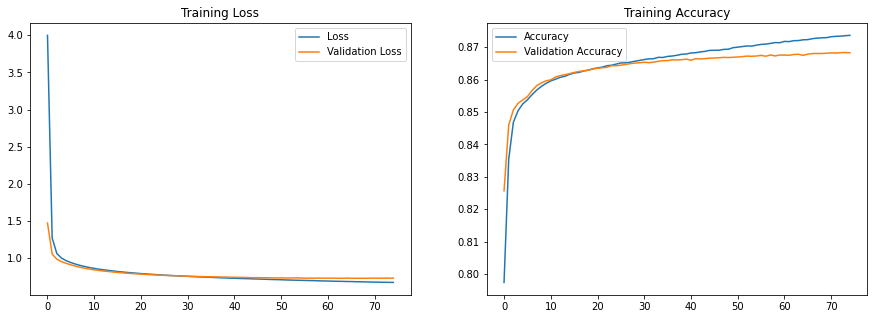

In [41]:
# Recupero il log di addestramento
df_history = pd.read_json(log_history, lines=True)

# visualizzazione andamento addestramento
# su un grafico composto da due sub-plot
# uno per il loss, l'altro per l'accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

# Errore durante l'addestramento
ax1.plot(df_history['loss'], label='Loss')
ax1.plot(df_history['val_loss'], label='Validation Loss')
ax1.set_title('Training Loss')
ax1.legend()

# Accuratezza durante l'addestramento
ax2.plot(df_history['sparse_categorical_accuracy'], label='Accuracy')
ax2.plot(df_history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
ax2.set_title('Training Accuracy')
ax2.legend()

plt.show()

### Test del modello
La seguente cella permette di caricare l'ultimo checkpoint dell'addestramento
precedentemente salvato.

In [42]:
# Carico i pesi modello
latest = tf.train.latest_checkpoint(PATH_WEIGHTS)
transformer.load_weights(latest)

In [43]:
class Translate:
  def __init__(self, transformer_block, tokenizers):
    self.transformer = transformer_block
    self.tokenizers = tokenizers

  def predict(self, input_text, max_length):
    if input_text is None:
      input_text = input_data[np.random.choice(len(input_data))]
      print(input_text)

    # print(input_text)
    inputs_encoder = self.tokenizers.ita.tokenize(input_text).to_tensor()
    inputs_encoder = keras.preprocessing.sequence.pad_sequences(inputs_encoder, maxlen=max_length, padding='post')

    # print(inputs_encoder)
    
    start_end = self.tokenizers.ita.tokenize([''])[0]
    start = start_end[0][tf.newaxis]
    end = (start_end[1][tf.newaxis]).numpy()[0]

    output_array = tf.TensorArray(dtype=tf.int64, size=max_length, dynamic_size=True)
    output_array = output_array.write(0, start)     

    out_words = []

    for i in tf.range(max_length):
      # decodifica e recupero probabilità di output
      output = tf.transpose(output_array.stack())
      
      transformer_output = transformer([inputs_encoder, output], 
                                        training=False,
                                        debug=False)

      predictions = transformer_output[:, -1:, :]

      # selezione della parola più probabile
      predict = tf.argmax(predictions, -1)
      pred_values = (K.argmax(transformer_output, axis=-1)).numpy()
    
      # inserimento della parola nella sequenza di output
      output_array = output_array.write(i+1, [pred_values[0][i]])

      if pred_values[0][i] == end:
        break

    output = tf.transpose(output_array.stack())
    text = tokenizers.dan.detokenize(output)[0]  

    tokens = tokenizers.dan.lookup(output)[0]

    return text, tokens

In [44]:
test_sequences = [test_input_data[41], test_input_data[30], test_input_data[10], 
                  test_input_data[57], test_input_data[82], test_input_data[15], 
                  test_input_data[4], test_input_data[42]]

translate = Translate(transformer_block=transformer,
                      tokenizers=tokenizers)

for test_sequence in test_sequences:
  text, token = translate.predict(tf.constant([test_sequence]), MAX_SEQ_LENGTH)

  print(f'{"Input:":15s}: {test_sequence}')
  print(f'{"Prediction":15s}: {text.numpy().decode("utf-8")}')  
  print('---------------------------------------------')

print(test_target_data[41])
print(test_target_data[30])
print(test_target_data[10])
print(test_target_data[57])
print(test_target_data[82])
print(test_target_data[15])
print(test_target_data[4])
print(test_target_data[42])

Input:         : sparare con alberi qualunque anima emerga
Prediction     : ma dimmi , ma dimmi , e non si ricaccia
---------------------------------------------
Input:         : con quella rabbia bruta che ho appena spento . 
Prediction     : che l acqua che l acqua si scontro e rivi .
---------------------------------------------
Input:         : come il diamante dove il sole si bagna . 
Prediction     : come l sol de la dove l sol desta .
---------------------------------------------
Input:         : che ce ne andiamo , perche abbiamo visto tutto . 
Prediction     : che tu hai che l ultima parola .
---------------------------------------------
Input:         : triangolo in modo che non abbia angolo retto . 
Prediction     : si che l a medenzion che non s accorse .
---------------------------------------------
Input:         : del loro numero , alcuni si tuffavano fino al sopracciglio , 
Prediction     : disper , e disper mi s accordanua ,
--------------------------------------------

### Tensorboard

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
log_dir

In [ ]:
%tensorboard --logdir drive/MyDrive/BERT/logs/fit/20221026-134720